# Data augementation

In [1]:
import os

if "visualization" in os.getcwd():
    os.chdir("..")

if "notebooks" in os.getcwd():
    os.chdir("..")
os.getcwd()

'/home/jordi/Documents/GitHub/zebra_fish'

In [2]:
from src.dataset import register_default_datasets
import numpy as np
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.data import detection_utils as utils, transforms as T, build_detection_train_loader
from detectron2.structures.masks import polygons_to_bitmask
from pathlib import Path
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.dataset_mapper import DatasetMapper

import random
import torch
import copy
import matplotlib.pyplot as plt

register_default_datasets()

In [3]:
def plot(data):
    original = utils.read_image(data["file_name"])
    
    img = data["image"].permute(1, 2, 0).double()
    img = (img - img.min()) / (img.max() - img.min())
    img *= 255
    
    height, width, _ = img.shape
    original_height, original_width, _ = original.shape
    

    data["instances"].pred_boxes = data["instances"].gt_boxes
    data["instances"].pred_classes = data["instances"].gt_classes
    data["instances"].scores = torch.ones_like(data["instances"].gt_classes)
    
    masks = []
    for polygon in data["instances"].gt_masks.polygons:
        masks.append(polygons_to_bitmask(polygon,  height, width))

    data["instances"].pred_masks = torch.from_numpy(np.array(masks))
    
    
    visualizer = Visualizer(img , metadata=meta_dataset, scale=0.5)
    out = visualizer.draw_instance_predictions(data["instances"])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    
    fig.suptitle(Path(data["file_name"]).name)
    ax1.imshow(out.get_image())
    ax1.set_title(f"h={height}, w={width} r={width / height}")
    ax2.imshow(original)
    ax2.set_title(f"h={original_height}, w={original_width} r={original_width / original_height}")
    plt.show()

## Config

In [4]:
name = "train"
meta_dataset = MetadataCatalog.get(name)
dataset = DatasetCatalog.get(name)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(meta_dataset.thing_classes)

## The default suggested augmentations

In [5]:
DatasetMapper(cfg, True).augmentations

[ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'),
 RandomFlip()]

## Custom Augmentations

In [6]:
augmentations = [
    T.ResizeShortestEdge(short_edge_length=cfg.INPUT.MIN_SIZE_TRAIN, max_size=cfg.INPUT.MAX_SIZE_TRAIN, sample_style=cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING),
    T.RandomRotation([0, 365], expand=False, center=[[0.45, 0.45], [0.55, 0.55]], sample_style="range"),
    T.RandomFlip(prob=0.5, horizontal=True),
]
mapper = DatasetMapper(
    is_train=True,
    augmentations=augmentations,
    image_format=cfg.INPUT.FORMAT,
    use_instance_mask=cfg.MODEL.MASK_ON,
    instance_mask_format=cfg.INPUT.MASK_FORMAT,
    use_keypoint=cfg.MODEL.KEYPOINT_ON,
    recompute_boxes=True,
)

## Demo of Augmentations

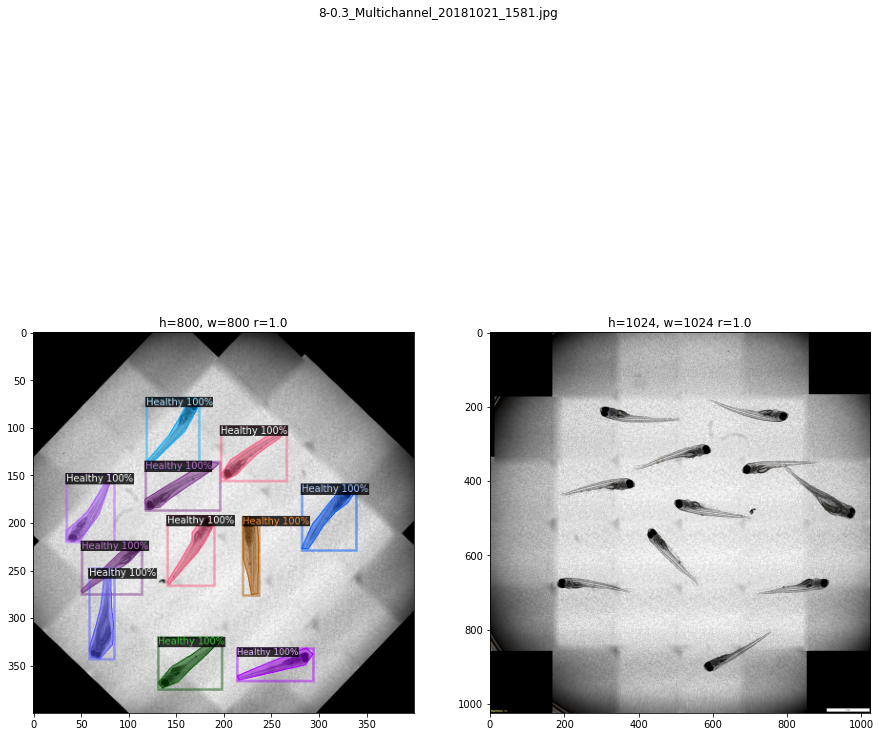

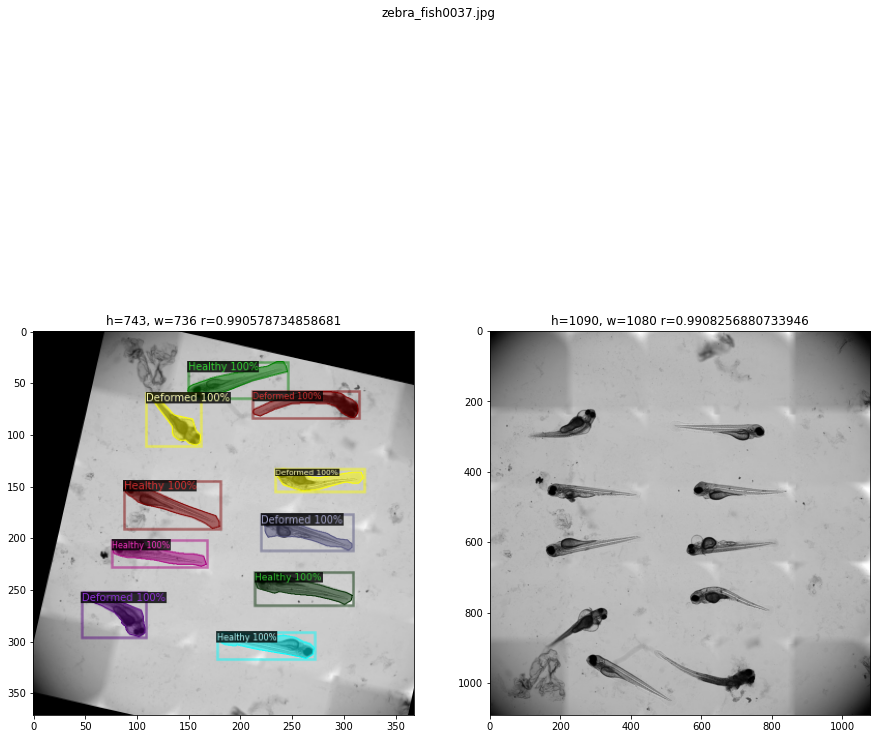

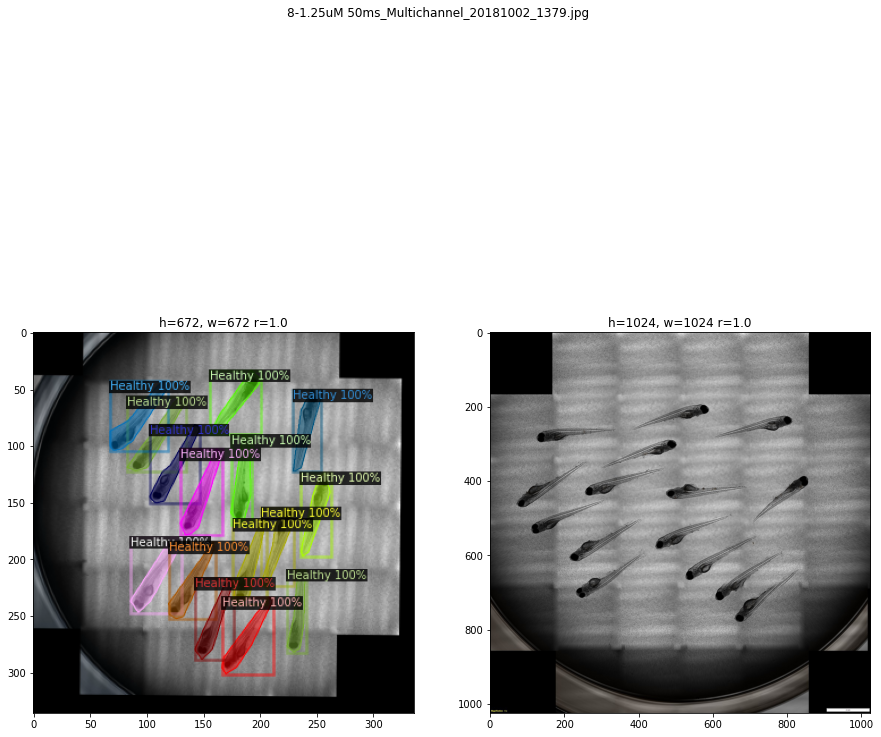

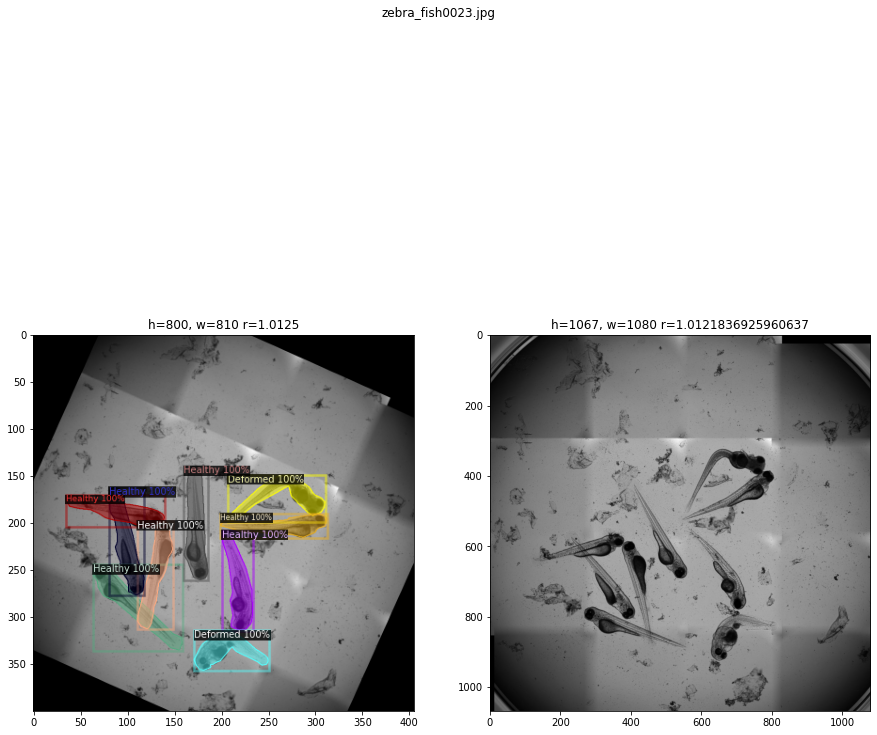

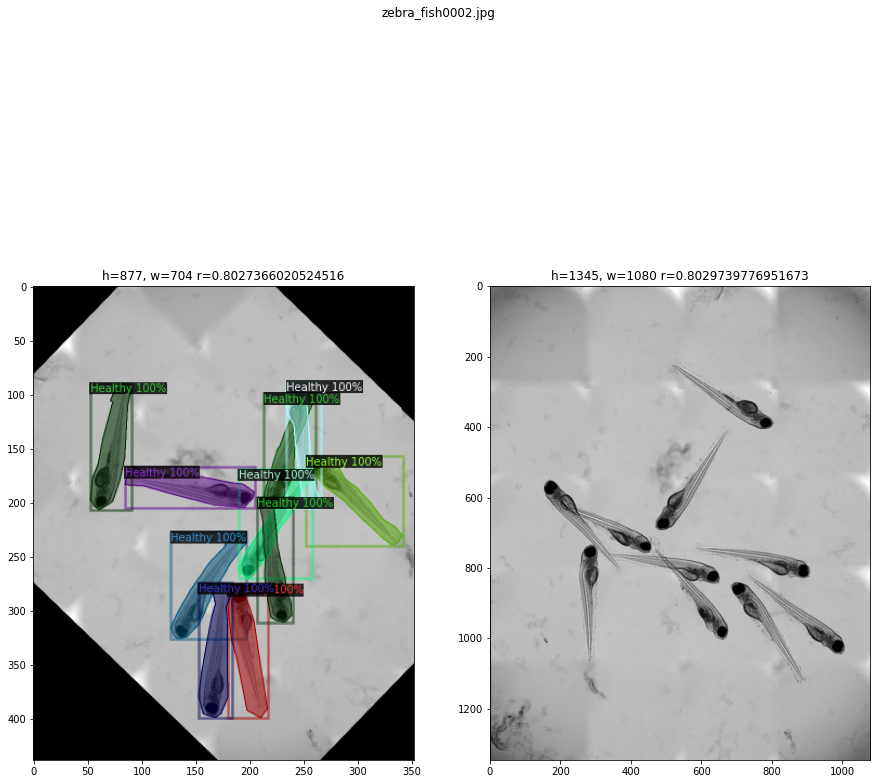

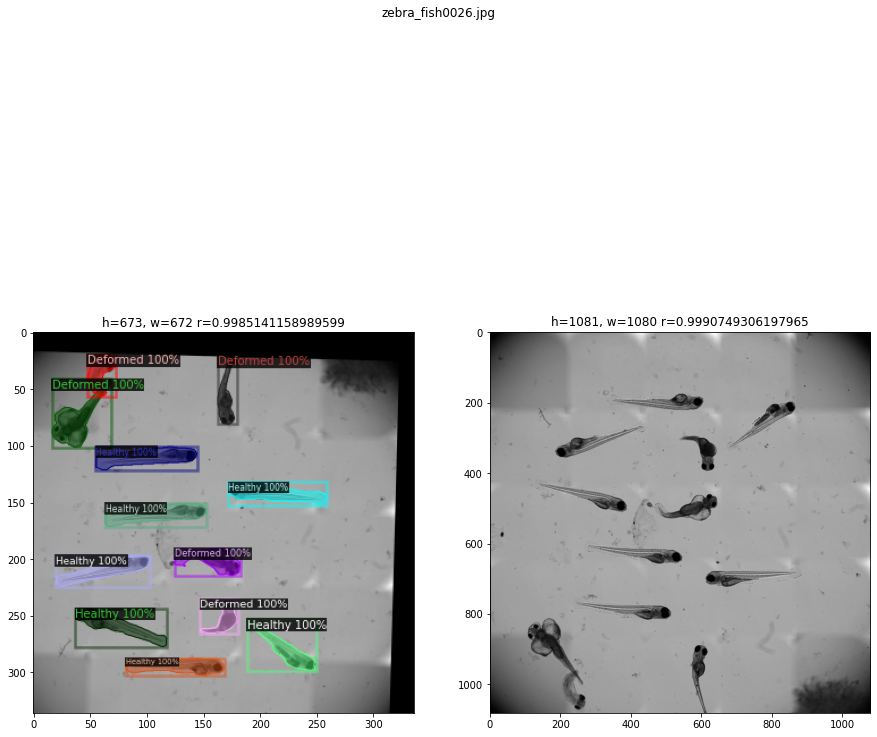

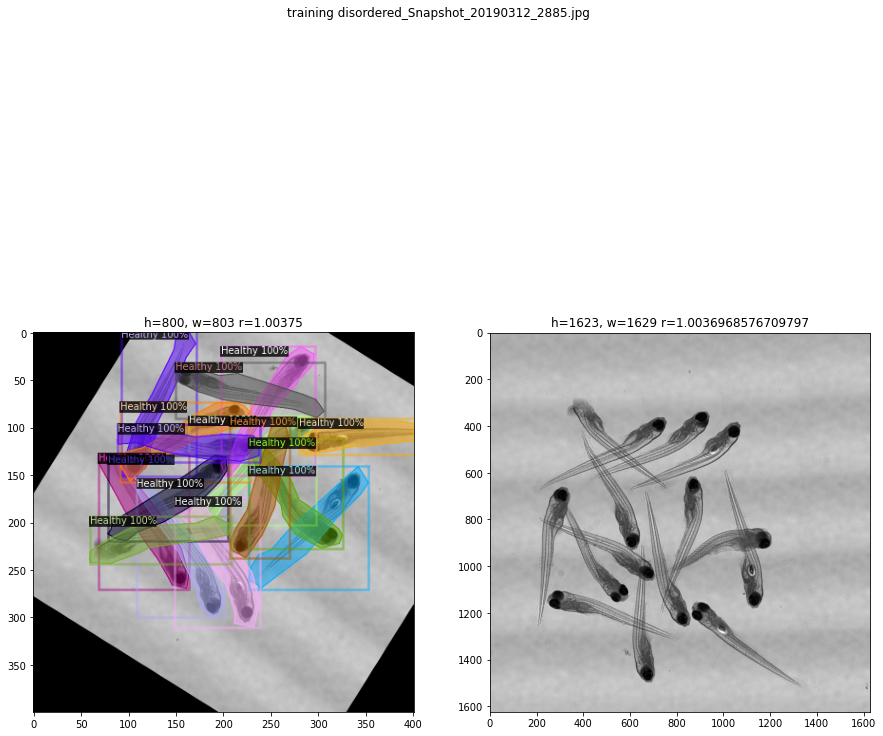

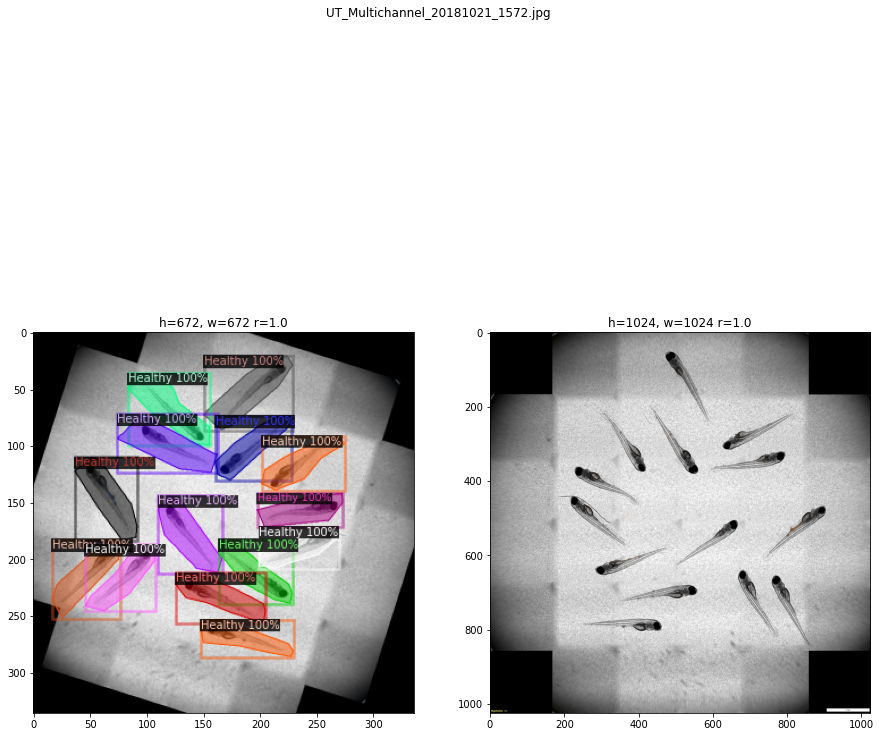

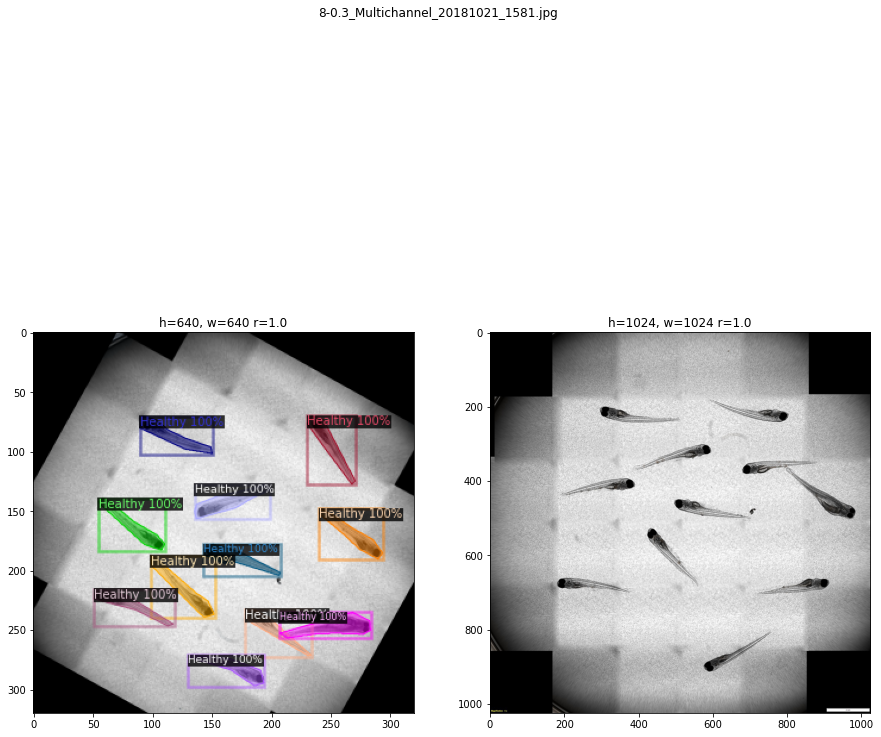

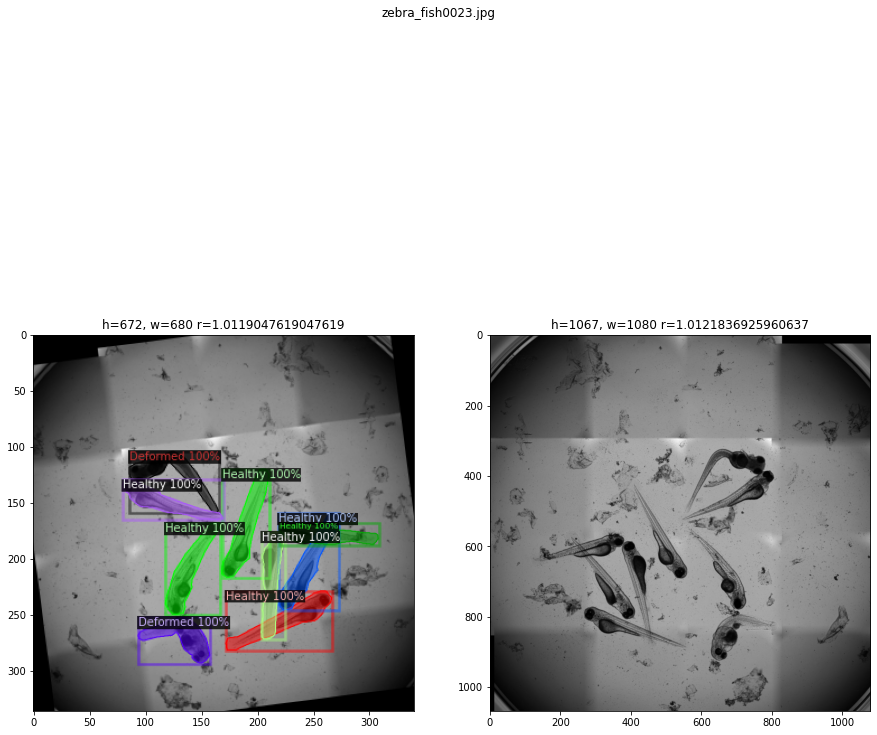

In [7]:
for item in random.choices(dataset, k=10):
    data = mapper(item)
    plot(data)